<!-- Autogenerated by `scripts/make_examples.py` -->
<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/voxel51/fiftyone-examples/blob/master/examples/pytorchvideo_tutorial.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791629-6e618700-5769-11eb-857f-d176b37d2496.png" height="32" width="32">
            Try in Google Colab
        </a>
    </td>
    <td>
        <a target="_blank" href="https://nbviewer.jupyter.org/github/voxel51/fiftyone-examples/blob/master/examples/pytorchvideo_tutorial.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791634-6efa1d80-5769-11eb-8a4c-71d6cb53ccf0.png" height="32" width="32">
            Share via nbviewer
        </a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/voxel51/fiftyone-examples/blob/master/examples/pytorchvideo_tutorial.ipynb">
            <img src="https://user-images.githubusercontent.com/25985824/104791633-6efa1d80-5769-11eb-8ee3-4b2123fe4b66.png" height="32" width="32">
            View on GitHub
        </a>
    </td>
    <td>
        <a href="https://github.com/voxel51/fiftyone-examples/raw/master/examples/pytorchvideo_tutorial.ipynb" download>
            <img src="https://user-images.githubusercontent.com/25985824/104792428-60f9cc00-576c-11eb-95a4-5709d803023a.png" height="32" width="32">
            Download notebook
        </a>
    </td>
</table>


# Evaluating PyTorchVideo models with FiftyOne

[PyTorchVideo](https://pytorchvideo.org/) is a new library that intends to make it just as easy to load and build video-based deep models as image models. They provide access to a video model zoo, video data processing functions, and a video-focused accelerator to deploy models all backed in PyThon allowing seamless integration into existing workflows.

The only thing missing from PyTorchVideo to complete your video workflows is a way to visualize your datasets and interpret your model results. This is where [FiftyOne](http://fiftyone.ai/) comes in. FiftyOne is an open-source tool designed to make it easy to load in and visualize any image or video dataset along with ground truth and predicted labels. The flexible representation of [FiftyOne datasets](https://voxel51.com/docs/fiftyone/user_guide/basics.html) and the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) let you quickly get hands-on with your datasets and interpret your model to find failure modes, annotation mistakes, visualize complex labels, and much more.

In this walkthrough, we will cover:

- Downloading a subset of the [Kinetics dataset](https://deepmind.com/research/open-source/kinetics)
- Loading a [video dataset in FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/datasets.html#videoclassificationdirectorytree-import)
- Using [PyTorchVideo to perform inference](https://pytorchvideo.org/docs/tutorial_torchhub_inference) on a FiftyOne dataset
- Visualizing and [evaluating the PyTorchVideo model using FiftyOne](https://voxel51.com/docs/fiftyone/tutorials/evaluate_classifications.html)


**So, what's the takeaway?**

Visualizing computer vision datasets is hard, especially for video data. Exploring datasets containing tens of thousands of samples with complex label types like detections or segmentations either requires significant custom scripting or is just skipped altogether. However, if you don't visualize, explore, and understand your dataset and model results, then you create an artificial ceiling for your model's performance.

FiftyOne allows you to easily view, explore, and evaluate image and video models and datasets. When paired with the new PyTorchVideo library, video-based ML workflows are now more efficient and thorough than ever before.

## Setup

*This walkthrough requires Python 3.7 or 3.8 for PyTorchVideo*


In [ ]:
# !pip install fiftyone

In [ ]:
# !pip install pytube

In [ ]:
!pip install torch torchvision

Note: For this walkthrough, PyTorchVideo needs to be [installed through GitHub](https://github.com/facebookresearch/pytorchvideo). Though otherwise it can be installed with:
```pip install pytorchvideo```

In [ ]:
# !git clone https://github.com/facebookresearch/pytorchvideo.git
# %cd pytorchvideo
# !pip install -e .
# %cd ..

**If you are running this is Google Colab** you will need to restart the runtime by uncommenting and running following command before running any other running cells. This is required to properly install PyTorchVideo from GitHub and a new version of TensorFlow in Colab.

In [ ]:
# exit()

This tutorial also includes some of FiftyOne’s [interactive plotting capabilities](https://voxel51.com/docs/fiftyone/user_guide/plots.html).

The recommended way to work with FiftyOne’s interactive plots is in [Jupyter notebooks](https://jupyter.org/) or [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/). In these environments, you can leverage the full power of plots by [attaching them to the FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/plots.html#attaching-plots) and bidirectionally interacting with the plots and the App to identify interesting subsets of your data.

To use interactive plots in Jupyter notebooks, ensure that you have the ipywidgets package installed:

In [ ]:
# !pip install ipywidgets>=7.5

If you’re working in JupyterLab, refer to [these instructions](https://voxel51.com/docs/fiftyone/user_guide/plots.html#working-in-notebooks) to get setup.

*Support for interactive plots in non-notebook contexts and Google Colab is coming soon! In the meantime, you can still use FiftyOne’s plotting features in those environments, but you must manually call plot.show() to update the state of a plot to match the state of a connected session, and any callbacks that would normally be triggered in response to interacting with a plot will not be triggered.*

### Prepare data

In this walkthrough, we are using a subset of the [Kinetics 400 action recognition dataset](https://deepmind.com/research/open-source/kinetics) composed of 400 human activity classes over 600,000 10-second long video clips sources from YouTube.

We will first need to download the labels for Kinetics as well as [youtube-dl](http://ytdl-org.github.io/youtube-dl/download.html) which we will use to download the video data from YouTube.

In [ ]:
# !python3 -m pip install --force-reinstall https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz

In [ ]:
# !wget https://storage.googleapis.com/deepmind-media/Datasets/kinetics400.tar.gz
# !tar -xvf ./kinetics400.tar.gz

In [ ]:
# from datetime import timedelta
# import json
# import os
# import subprocess

# import yt_dlp as youtube_dl
# from yt_dlp.utils import (DownloadError, ExtractorError)

# def download_video(url, start, dur, output):
#     output_tmp = os.path.join("/tmp",os.path.basename(output))
#     try:
#     # From https://stackoverflow.com/questions/57131049/is-it-possible-to-download-a-specific-part-of-a-file
#         with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
#             result = ydl.extract_info(url, download=False)
#             video = result['entries'][0] if 'entries' in result else result

#         url = video['url']
#         if start < 5:
#             offset = start
#         else:
#             offset = 5
#         start -= offset
#         offset_dur = dur + offset
#         start_str = str(timedelta(seconds=start))
#         dur_str = str(timedelta(seconds=offset_dur))

#         cmd = ['ffmpeg', '-i', url, '-ss', start_str, '-t', dur_str, '-c:v',
#                 'copy', '-c:a', 'copy', output_tmp]
#         subprocess.call(cmd)

#         start_str_2 = str(timedelta(seconds=offset))
#         dur_str_2 = str(timedelta(seconds=dur))

#         cmd = ['ffmpeg', '-i', output_tmp, '-ss', start_str_2, '-t', dur_str_2, output]
#         subprocess.call(cmd)
#         return True

#     except (DownloadError, ExtractorError) as e:
#         print("Failed to download %s" % output)
#         return False

# with open("./kinetics400/test.json", "r") as f:
#     test_data = json.load(f)

# target_classes = [
#  'springboard diving',
#  'surfing water',
#  'swimming backstroke',
#  'swimming breast stroke',
#  'swimming butterfly stroke',
# ]
# data_dir = "./videos"
# max_samples = 5

# classes_count = {c:0 for c in target_classes}

# for fn, data in test_data.items():
#     label = data["annotations"]["label"]
#     segment = data["annotations"]["segment"]
#     url = data["url"]
#     dur = data["duration"]
#     if label in classes_count and classes_count[label] < max_samples:
#         c_dir = os.path.join(data_dir, label)
#         if not os.path.exists(c_dir):
#             os.makedirs(c_dir)


#         start = segment[0]
#         output = os.path.join(c_dir, "%s_%s.mp4" % (label.replace(" ","_"), fn))

#         results = True
#         if not os.path.exists(output):
#             result = download_video(url, start, dur, output)
#         if result:
#             classes_count[label] += 1

# print("Finished downloading videos!")

## Load dataset in FiftyOne

FiftyOne is designed to make it as easy as possible to [load and visualize your image and video datasets](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html) even with complex label types like detections and segmentations.

If your dataset follows a common format, like the [COCO format for detections](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/datasets.html#cocodetectiondataset-import), then you can load it in a single line of code. Even if you use a [custom format](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/samples.html), you can always easily load your labels manually.

In this example, we will be following the [PyTorchVision tutorial](https://pytorchvideo.org/docs/tutorial_torchhub_inference) on running a video classification model. Generally, video classification datasets will be [stored on disk in a directory tree](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/datasets.html#videoclassificationdirectorytree-import) whose subfolders define dataset classes. This format can be loaded in one line of code:

In [ ]:
import fiftyone as fo
# import fiftyone.zoo as foz

Subprocess ['/home/samateen/.local/lib/python3.10/site-packages/fiftyone/db/bin/mongod', '--dbpath', '/home/samateen/.fiftyone/var/lib/mongo', '--logpath', '/home/samateen/.fiftyone/var/lib/mongo/log/mongo.log', '--port', '0', '--nounixsocket'] exited with error 127:
/home/samateen/.local/lib/python3.10/site-packages/fiftyone/db/bin/mongod: error while loading shared libraries: libcurl.so.4: cannot open shared object file: No such file or directory


In [ ]:
name = "phase-recog"
labels_path = "data/test.csv"

fields = {
    "filepath": None,  # load as strings
    "class-label": lambda v: fo.Classification(label=v) if v else None,
}

# Import CSV file with absolute media paths and custom field parsers
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.CSVDataset,
    labels_path=labels_path,
    fields=fields,
    name=name,
)
# dataset = foz.load_zoo_dataset(
#     "kinetics-400",
#     split="validation",
#     max_samples=10,
#     shuffle=True,
# )

Let's launch the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) and look at the data we loaded. Hover over or click on the samples to play the videos.

In [ ]:
# Launch the App and view the dataset
session = fo.launch_app(dataset)

In [ ]:
session.freeze()

FiftyOne datasets also allow you to [store a list of default class names](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#storing-class-lists) that will be used when evaluating predictions.

In [ ]:
!wget https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json

--2024-02-18 21:19:22--  https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.10, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10326 (10K) [text/plain]
Saving to: ‘kinetics_classnames.json’

kinetics_classnames 100%[===================>]  10.08K  --.-KB/s    in 0s      

2024-02-18 21:19:22 (95.0 MB/s) - ‘kinetics_classnames.json’ saved [10326/10326]



In [ ]:
import json

In [ ]:
with open("kinetics_classnames.json", "r") as f:
    kinetics_classnames = json.load(f)

# Sort and format classes
dataset.default_classes = sorted([c.replace('"','') for c in kinetics_classnames.keys()])

## Running a PyTorchVideo model

In this section, we use PyTorchVideo download and run a video classification model on the data that we previously loaded and store the results in FiftyOne.

[Torch Hub](https://pytorch.org/hub/) is a repository for pretrained PyTorch models that allow you to easily download and run inference on your dataset. PyTorchVideo provides a number of video classification models through their [Torch Hub-backed model zoo](https://pytorchvideo.readthedocs.io/en/latest/model_zoo.html) including SlowFast, I3D, C2D, R(2+1)D, and X3D. The following downloads the slow branch of SlowFast with a ResNet50 backbone and loads it into Python:

In [ ]:
import json
import torch
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [ ]:
# Device on which to run the model
#device = "cuda:0"
device = "cuda"

# Pick a pretrained model
# model_name = "slow_r50"

# Local path to the parent folder of hubconf.py in the pytorchvideo codebase
path = 'pytorchvideo'
# model = torch.hub.load(path, source="local", model=model_name, pretrained=False)
model_name = "mvit_base_32x3"
model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=False)


# model_url = "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOW_8x8_R50.pyth"
model_url = "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/MVIT_B_32x3_f294077834.pyth"


checkpoint = torch.hub.load_state_dict_from_url(model_url, map_location=device)
state_dict = checkpoint["model_state"]

# Apply the state dict to the model
model.load_state_dict(state_dict)

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/MVIT_B_32x3_f294077834.pyth" to /root/.cache/torch/hub/checkpoints/MVIT_B_32x3_f294077834.pyth
100%|██████████| 419M/419M [00:16<00:00, 26.0MB/s]


<All keys matched successfully>

In [ ]:
# Set to eval mode and move to desired device
model = model.eval()
model = model.to(device)

In [ ]:
# Create an id to label name mapping
kinetics_id_to_classname = {v:k for v,k in enumerate(dataset.default_classes)}

Every model has a specific input that it expects. The standard workflow is to write custom scripts that perform the necessary loading and transformation functions to format data for every model. PyTorchVision makes this process easier by [providing these functions](https://pytorchvideo.readthedocs.io/en/latest/transforms.html) for you in a flexible way that will work for most video processing needs. For example, the following code constructs the PyTorch transforms to sample frames from the video, normalize, scale, and crop it, without needing to write any of those functions yourself:


In [ ]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 224
num_frames = 32

In [ ]:
# Note that this transform is specific to the slow_R50 model.
# If you want to try another of the torch hub models you will need to modify this transform
transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size=(crop_size, crop_size))
        ]
    ),
)

Since the dataset is being stored in FiftyOne, we can easily iterate through the samples, load and run our model on them with PyTorchVideo, and store the predictions back in FiftyOne for further visualization and analysis:

In [ ]:
from pytorchvideo.data.encoded_video import EncodedVideo

In [ ]:
import fiftyone.core.utils as fouo

In [ ]:
def parse_predictions(preds, kinetics_id_to_classname, k=5):
    preds_topk = preds.topk(k=k)
    pred_classes = preds_topk.indices[0]
    pred_scores = preds_topk.values[0]

    preds_top1 = preds.topk(k=1)
    pred_class = preds_top1.indices[0]
    pred_score = preds_top1.values[0]

    # Map the predicted classes to the label names
    pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
    pred_class_name = kinetics_id_to_classname[int(pred_class)]

    prediction_top_1 = fo.Classification(
        label=pred_class_name,
        confidence=pred_score,
    )
    predictions_top_k = []

    for l, c in zip(pred_class_names, pred_scores):
        cls = fo.Classification(label=l, confidence=c)
        predictions_top_k.append(cls)

    predictions_top_k = fo.Classifications(classifications=predictions_top_k)

    return prediction_top_1, predictions_top_k

In [ ]:
with torch.no_grad():
    with fouo.ProgressBar() as pb:
        for sample in pb(dataset):
            video_path = sample.filepath

            # Initialize an EncodedVideo helper class
            video = EncodedVideo.from_path(video_path)

            # Select the duration of the clip to load by specifying the start and end duration
            # The start_sec should correspond to where the action occurs in the video
            start_sec = 0
            clip_duration = int(video.duration)
            end_sec = start_sec + clip_duration

            # Load the desired clip
            video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

            # Apply a transform to normalize the video input
            video_data = transform(video_data)

            # Move the inputs to the desired device
            inputs = video_data["video"]
            inputs = inputs.to(device)

            # Pass the input clip through the model
            preds_pre_act = model(inputs[None, ...])

            # Get the predicted classes
            post_act = torch.nn.Softmax(dim=1)
            preds = post_act(preds_pre_act)

            # Generate FiftyOne labels from predictions
            prediction_top_1, predictions_top_5 = parse_predictions(preds, kinetics_id_to_classname, k=5)

            # Add FiftyOne label fields to Sample
            sample["predictions"] = prediction_top_1
            sample["predictions_top_5"] = predictions_top_5
            sample.save()

 100% |███████████████████| 10/10 [22.5s elapsed, 0s remaining, 0.4 samples/s]    


INFO:eta.core.utils: 100% |███████████████████| 10/10 [22.5s elapsed, 0s remaining, 0.4 samples/s]    


We can now see that the [fields](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#fields) `predictions` and `predictions_top_5` have been added to our dataset.

In [ ]:
dataset

Name:        kinetics-400-validation-10
Media type:  video
Num samples: 10
Persistent:  False
Tags:        []
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.VideoMetadata)
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    predictions:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    predictions_top_5: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
Frame fields:
    id:           fiftyone.core.fields.ObjectIdField
    frame_number: fiftyone.core.fields.FrameNumberField

## Evaluating a model with FiftyOne

Aside from being an open-source ecosystem for dataset curation, FiftyOne is also designed to visualize, evaluate, and interpret models by allowing you to quickly [find and address model failure modes](https://voxel51.com/docs/fiftyone/tutorials/evaluate_classifications.html).

To this end, we can start by visualizing the predictions generated in the last section in FiftyOne:

In [ ]:
session = fo.launch_app(dataset)

In [ ]:
session.freeze()

We can then use [FiftyOne to evaluate](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html) the predictions with the ground truth to view aggregate metrics and plots showing things like [confusion matrices](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#confusion-matrices) and [precision-recall curves](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#binary-evaluation). Evaluation can be performed in just a single line of code:

In [ ]:
results = dataset.evaluate_classifications("predictions", "ground_truth", eval_key="eval")

In [ ]:
target_classes = [
 'springboard diving',
 'surfing water',
 'swimming backstroke',
 'swimming breast stroke',
 'swimming butterfly stroke',
]
results.print_report(classes=target_classes)

                           precision    recall  f1-score   support

       springboard diving       0.80      0.80      0.80         5
            surfing water       1.00      0.60      0.75         5
      swimming backstroke       1.00      0.80      0.89         5
   swimming breast stroke       0.57      0.80      0.67         5
swimming butterfly stroke       1.00      0.60      0.75         5

                micro avg       0.82      0.72      0.77        25
                macro avg       0.87      0.72      0.77        25
             weighted avg       0.87      0.72      0.77        25



Let's plot the confusion matrix for the classes we are interested in:

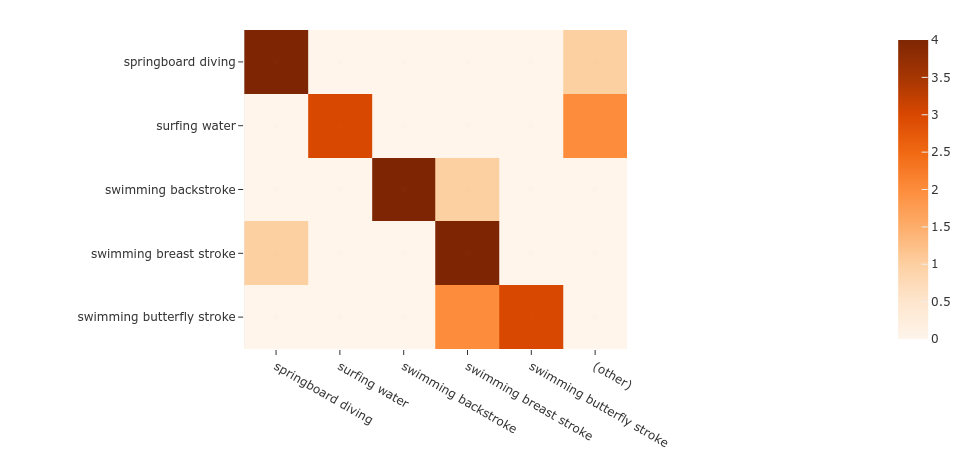

In [ ]:
plot = results.plot_confusion_matrix(classes=target_classes)
plot.show()

We can attach this plot to a session object to make it [interactive](https://voxel51.com/docs/fiftyone/user_guide/plots.html). So if you click one of the cells, the FiftyOne App session updates to show the samples in that cell.

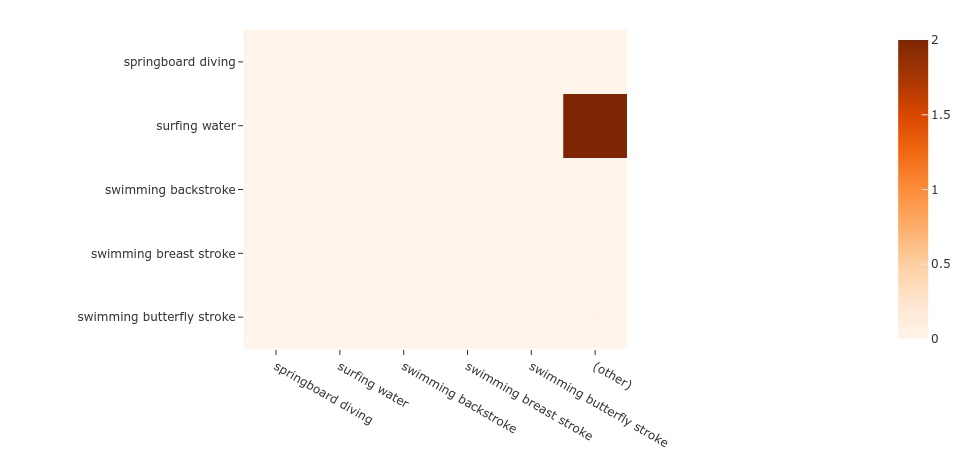

In [ ]:
plot = results.plot_confusion_matrix(classes=target_classes)
plot.show()


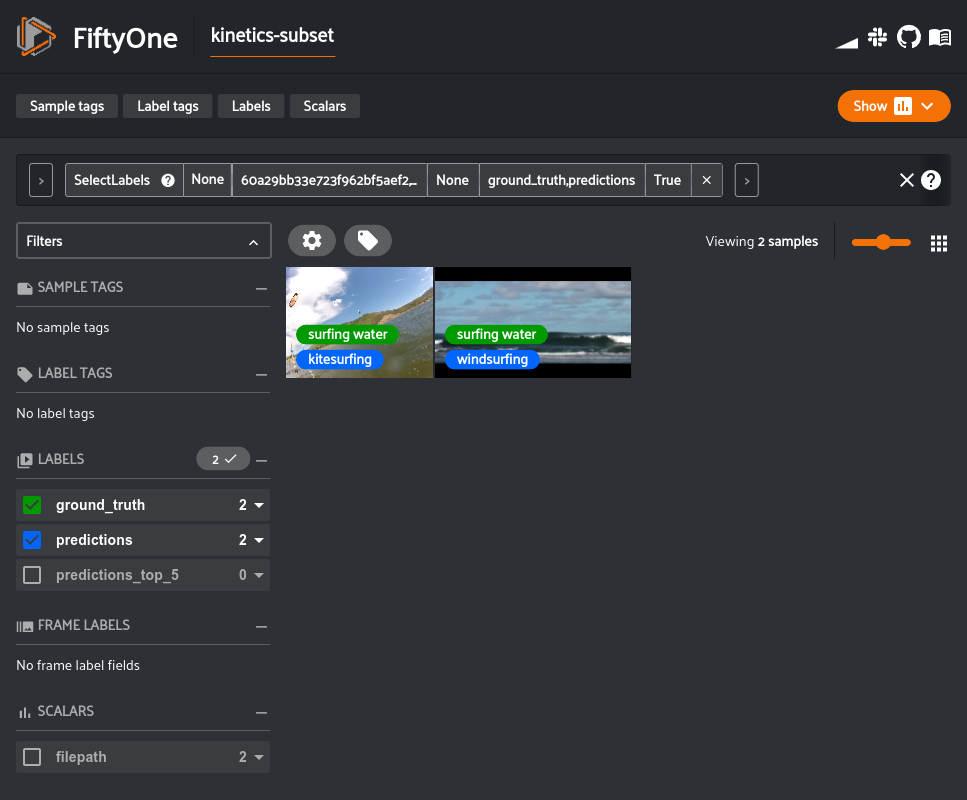

In [ ]:
session = fo.launch_app(dataset)

In [ ]:
# If you are in a Jupyter notebook, attach plot to session
session.plots.attach(plot)

*Note: Plots are currently only interactive in Jupyter Notebooks but additional environments will be supported soon!*

In [ ]:
session.freeze()  # screenshot App and attached plots

FiftyOne also provides a novel query language to [create views](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) into your dataset by [searching and filtering](https://voxel51.com/docs/fiftyone/user_guide/using_views.html#filtering) any given labels and metadata. This makes it easy to explore your dataset and find samples related to any question you may have in mind. For example, we can quickly find samples where the model was least certain about its prediction based on similar confidences across multiple classes:

In [ ]:
from fiftyone import ViewField as F

false_view = (
    dataset
    .sort_by(
        F("predictions_top_5.classifications.confidence").std(),
    )
    .match(F("eval") == False)
)

Visualizing these samples lets us get an idea of the type of data that should be added to the training dataset or presented more often in the training pipeline:


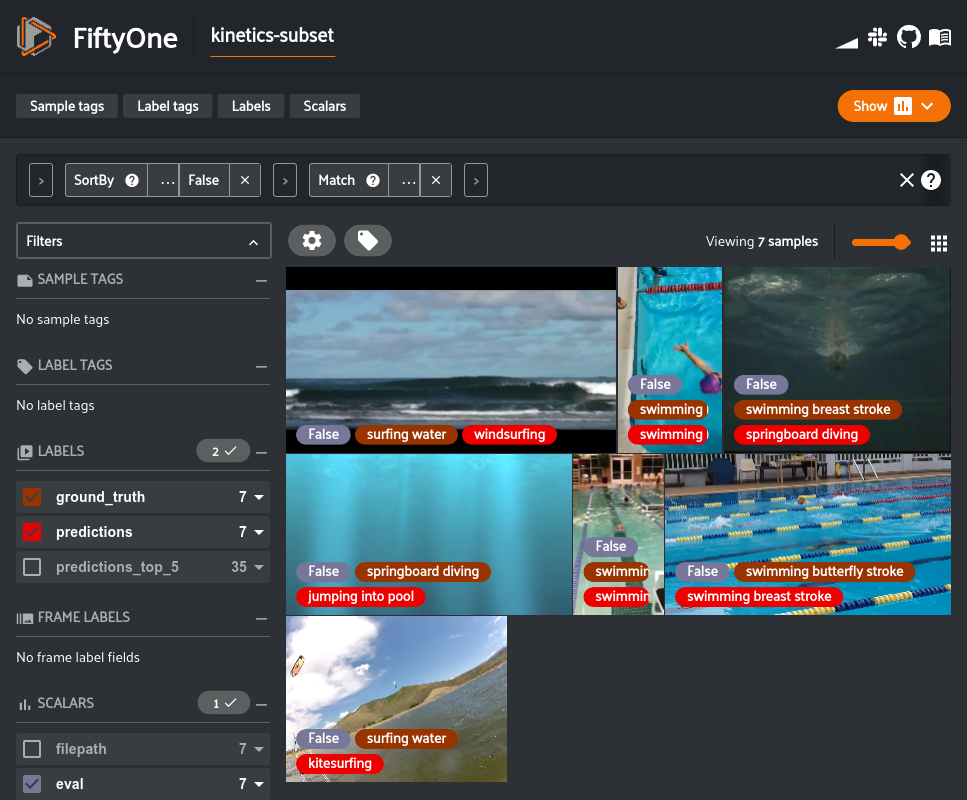

In [ ]:
session = fo.launch_app(view=false_view)

In [ ]:
session.freeze()  # screenshot App

We can tag these using the [tagging functionality in the FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging) so that we can easily refer to them later:


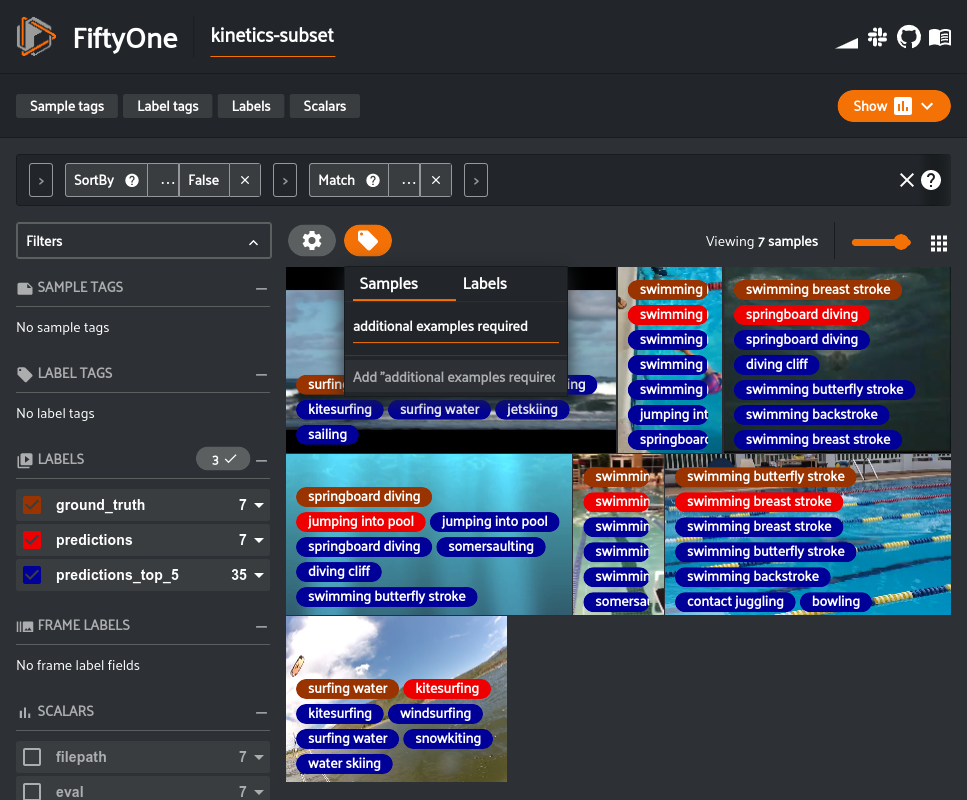

In [ ]:
session = fo.launch_app(view=false_view)

In [ ]:
session.freeze()  # screenshot App

The ease of this hands-on analysis will generally lead to significant improvements in dataset quality, and consequently improvements in model performance, faster than any analysis only using aggregate dataset statistics.

### Object detection in video

While most large video datasets and research efforts revolve around classification problems like human activity recognition, applications of video-based ML are often centered more around object detection. At the moment, PyTorchVideo primarily supports video classification problems, however, there are video object detection capabilities available in FiftyOne.

FiftyOne allows you to either generate predictions from an image-based object detection model in the [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html#basic-recipe) or [add predictions from your own model](https://voxel51.com/docs/fiftyone/recipes/adding_detections.html) to a video dataset. In this example, let's use [EfficientDet-D0](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/models.html#efficientdet-d0-coco-tf1), a detection model backed by [TensorFlow](https://www.tensorflow.org/) and [AutoML](https://github.com/google/automl). We can use [eta](https://github.com/voxel51/eta), a package installed with FiftyOne, to install AutoML.

In [ ]:
!eta install automl

Applying a zoo model only requires a few lines of code:

In [ ]:
import fiftyone.zoo as foz

In this example, we will be loading an image-based object detector and running it frame-wise on our video dataset.

In [ ]:
model = foz.load_zoo_model("efficientdet-d0-coco-tf1")

Let's take one springboard diving video and run the detector on every frame of the video.

In [ ]:
subset = dataset.take(1, seed=51)

In [ ]:
subset.apply_model(model, "detections")

 100% |█████████████████| 270/270 [1.8m elapsed, 0s remaining, 2.8 samples/s]      



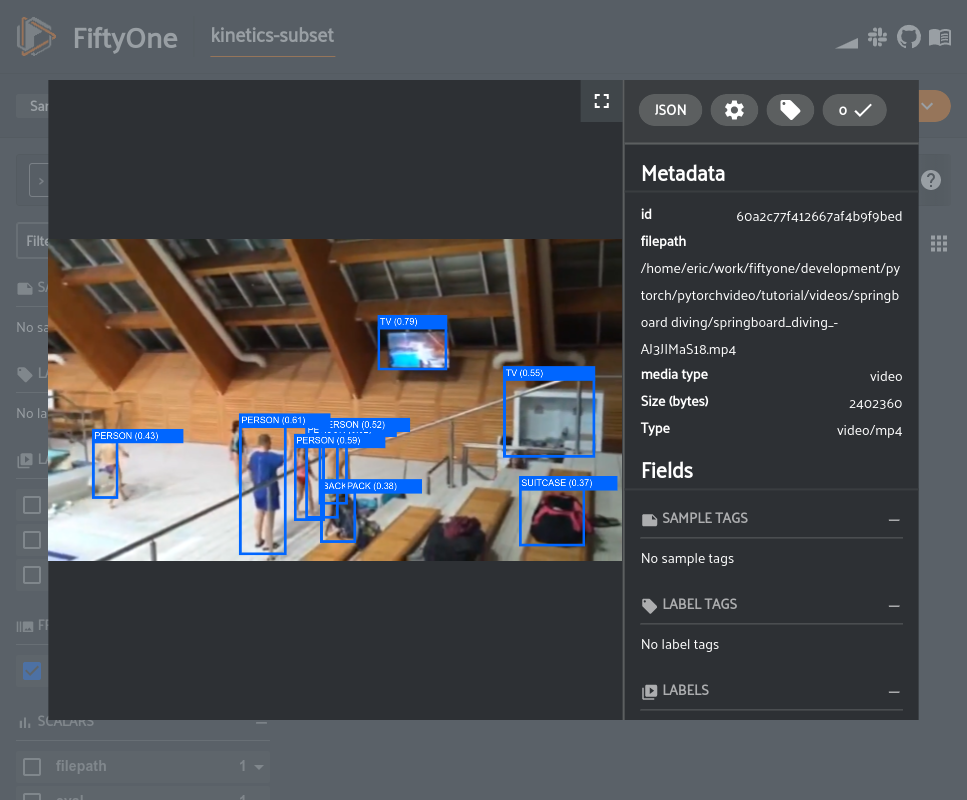

In [ ]:
session = fo.launch_app(view=subset)

In [ ]:
session.freeze()

This kind of visualization would require writing custom scripts to load the raw video, annotations, and predictions, then using something like [OpenCV](https://opencv.org/) to draw boxes and export the visualizations to a new video on disk. Then if you want to change the labels you are looking at you would need to rewrite your script and regenerate the videos every time. Instead, all of this took us only a few lines of code and resulted in an easier-to-use and more flexible representation of our data.

## Summary

This walkthrough an example of integrating PyTorchVideo with FiftyOne. Specifically, we covered:

- Downloading a subset of the [Kinetics dataset](https://deepmind.com/research/open-source/kinetics)
- Loading a [video dataset in FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/datasets.html#videoclassificationdirectorytree-import)
- Using [PyTorchVideo to perform inference](https://pytorchvideo.org/docs/tutorial_torchhub_inference) on a FiftyOne dataset
- Visualizing and [evaluating the PyTorchVideo model using FiftyOne](https://voxel51.com/docs/fiftyone/tutorials/evaluate_classifications.html)

**So, what's the takeaway?**

Video-based machine learning models are growing in popularity but have lacked the same level of ease-of-use code bases that allow for quick development and evaluation of image models. [PyTorchVideo](https://pytorchvideo.org/) aims to make it easier to implement, train, and evaluate video models through their model zoo, video-focused components, and acceleration functions. On the flip side, where PyTorchVideo is making it easier to work with video models, [FiftyOne](http://fiftyone.ai/) is an open-source library that aims to make it easy and efficient to curate, evaluate, and improve video (and image) datasets. Together, FiftyOne and PyTorchVideo provide significant savings in the time and effort required to create high-quality video datasets and models.